In [1]:
import os
import re
import sys
import string
import modSpellChecker_1 as sc
from contractions_1 import CONTRACTION_MAP
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import numpy as np
import pandas as pd
import operator

In [2]:
character = ['z','y','x','w','v','u','t','s','r','q','p','o','n','m','l','k','j','i','h','g','f','e','d',',',';',':','-','...','?','!', '(',')','[',']','{','}','<','>', '"','/','\'','#','-','@']

def repeatcharNormalize(text):
    for i in range(len(character)):
        charac_long = 5
        while charac_long >= 2:
            char = character[i] * charac_long
            text = text.replace(char, character[i])
            charac_long -= 1
    return text

def spellNormalize(text):
    spellCheck = []
    for i in text:
        if i not in character:
            j = sc.correction(i)
            spellCheck.append(j)
        else:
            spellCheck.append(i)
    return spellCheck

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

def expand_contractions(text, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def stemmer_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = stemmer.stem(text)
    return text

In [3]:
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('',token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [4]:
factory = StopWordRemoverFactory()
stopword_list = factory.get_stop_words()

In [5]:
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [6]:
def normalize_corpus(corpus, tokenize=False):
    normalized_corpus = []
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
        text = stemmer_text(text)
        text = remove_special_characters(text)
        text = repeatcharNormalize(text)
        text = remove_stopwords(text)
        normalized_corpus.append(text)
        if tokenize:
            text = tokenize_text(text)
            text = spellNormalize(text)
            normalized_corpus.append(text)
    return normalized_corpus

Penyiapan Data Teks

In [7]:
dataset = pd.read_csv('cnn_sport.csv')
dataset

,title,category,link
0,Klasemen Liga Inggris: Tottenham Gusur Man Cit...,Sepakbola,https://www.cnnindonesia.com/olahraga/20231024...
1,Khamzat Disebut Tak Pantas Dapat Duel Gelar Ju...,Olahraga Lainnya,https://www.cnnindonesia.com/olahraga/20231023...
2,"Hasil Liga Inggris: Son Cetak Gol, Tottenham H...",Sepakbola,https://www.cnnindonesia.com/olahraga/20231024...
3,Binder Merasa Kasihan Martin Gagal Menang di M...,Moto GP,https://www.cnnindonesia.com/olahraga/20231024...
4,FOTO: Tottenham Jaga Rekor Belum Terkalahkan U...,Sepakbola,https://www.cnnindonesia.com/olahraga/20231024...
...,...,...,...
1995,Jadwal Siaran Langsung Final Hong Kong Open: 3...,Raket,https://www.cnnindonesia.com/olahraga/20230917...
1996,Klasemen Liga Inggris Usai MU Terpuruk di Old ...,Sepakbola,https://www.cnnindonesia.com/olahraga/20230917...
1997,Ronaldo Tunjukkan Gairah Besar di Saudi Pro Le...,Sepakbola,https://www.cnnindonesia.com/olahraga/20230917...
1998,"2 Pemain Al Raed Berebut Tendang Penalti, Rona...",Sepakbola,https://www.cnnindonesia.com/olahraga/20230917...


In [8]:
feature = dataset.iloc[:,0]

In [9]:
feature[0:10]

0    Klasemen Liga Inggris: Tottenham Gusur Man Cit...
1    Khamzat Disebut Tak Pantas Dapat Duel Gelar Ju...
2    Hasil Liga Inggris: Son Cetak Gol, Tottenham H...
3    Binder Merasa Kasihan Martin Gagal Menang di M...
4    FOTO: Tottenham Jaga Rekor Belum Terkalahkan U...
5    INFOGRAFIS: Jadwal Timnas Indonesia di Kualifi...
6          Messi Banggakan Capaian Bersama Inter Miami
7    Erick Thohir Soal Persiapan Piala Dunia U-17: ...
8    Bagnaia Mulai Pongah Jelang MotoGP Thailand da...
9    Sidang Komdis PSSI: Hugo Samir Pukul Pemain Pe...
Name: title, dtype: object

In [10]:
norm_corpus = normalize_corpus(feature)
len(norm_corpus)

2000

In [11]:
norm_corpus

['klasemen liga ingris totenham gusur man city puncak',
 'khamzat sebut tak pantas duel gelar juara ufc',
 'hasil liga ingris son cetak gol totenham hajar fulham 20',
 'binder rasa kasihan martin gagal menang motogp australia',
 'foto totenham jaga rekor kalah usai hajar fulham',
 'infografis jadwal timnas indonesia kualifikasi piala dunia 2026',
 'mesi banga capai sama inter miami',
 'erick thohir soal siap piala dunia u17 fifa beri jempol',
 'bagnaia mulai pongah jelang motogp thailand malaysia',
 'sidang komdis psi hugo samir pukul main persib hukum 2 laga',
 'daftar main indonesia french open 2023',
 'bolden jadi main nba usai terima twoway contract bucks',
 'reaksi ibu welber jardim usai sang anak fasih bahasa indonesia',
 'psi ajak warga bandung tonton piala dunia u17 bukti gila bola',
 'bantai filipina timnas futsal putri indonesia juara turnamen invitasi',
 'link live streaming persija vs rans liga 1',
 'top 3 sports zarco juara motogp australia makhachev menang ko',
 'chow yun

In [12]:
test_data = [
    'Sprint Race MotoGP Batal: Martin Kecewa Gagal Dekati Bagnaia',
    'Klasemen Liga Inggris: Tottenham Gusur Man City dari Puncak',
    'Messi Banggakan Capaian Bersama Inter Miami',
    'Indonesia Tambah Dua Perunggu Para Games Lewat Blind Judo',
    'Hokky Caraka Soal Gol Dianulir: Lawan Wasit Susah Menang'
]


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Menggunakan TfidfVectorizer untuk mengonversi teks menjadi vektor TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidf_matrix = vectorizer.fit_transform(norm_corpus + test_data)

# Menghitung cosine similarity antara dokumen dalam norm_corpus dan data uji
cosine_similarities = cosine_similarity(tfidf_matrix[-len(test_data):], tfidf_matrix[:-len(test_data)])
correct_predictions=0
# Menghitung akurasi
for i in range(len(test_data)):
    predicted_index = cosine_similarities[i].argmax()
    print(f'Test Data: {test_data[i]}')
    print(f'Predicted Document: {norm_corpus[predicted_index]}')
    print(f'Cosine Similarity: {cosine_similarities[i][predicted_index]}')
    print('---')
    if cosine_similarities[i][predicted_index] >= 0.7:
        correct_predictions+=1
        
        


accuracy = correct_predictions / len(test_data)
print(f'Accuracy: {accuracy * 100:.2f}%')


Test Data: Sprint Race MotoGP Batal: Martin Kecewa Gagal Dekati Bagnaia
Predicted Document: sprint race motogp batal martin kecewa gagal dekat bagnaia
Cosine Similarity: 0.9547140676771952
---
Test Data: Klasemen Liga Inggris: Tottenham Gusur Man City dari Puncak
Predicted Document: klasemen liga ingris totenham gusur man city puncak
Cosine Similarity: 0.8193446747218048
---
Test Data: Messi Banggakan Capaian Bersama Inter Miami
Predicted Document: mesi banga capai sama inter miami
Cosine Similarity: 0.6257276205399779
---
Test Data: Indonesia Tambah Dua Perunggu Para Games Lewat Blind Judo
Predicted Document: indonesia tambah perungu games lewat blind judo
Cosine Similarity: 0.9040464892329321
---
Test Data: Hokky Caraka Soal Gol Dianulir: Lawan Wasit Susah Menang
Predicted Document: hoky caraka soal gol anulir lawan wasit susah menang
Cosine Similarity: 0.845044935747726
---
Accuracy: 80.00%


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidf_matrix = tf.fit_transform(norm_corpus)
tfidf_matrix.shape

(2000, 2862)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
doc_sim = cosine_similarity(tfidf_matrix)
doc_sim_df = pd.DataFrame(doc_sim)
doc_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,1.000000,0.0,0.196113,0.0,0.081744,0.0,0.0,0.0,0.000000,0.0,...,0.321987,0.0,0.0,0.000000,0.0,0.0,0.255013,0.0,0.0,0.028092
1,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.196113,0.0,1.000000,0.0,0.363310,0.0,0.0,0.0,0.000000,0.0,...,0.219156,0.0,0.0,0.135407,0.0,0.0,0.126328,0.0,0.0,0.224574
3,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.032944,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.081744,0.0,0.363310,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,...,0.055893,0.0,0.0,0.000000,0.0,0.0,0.030026,0.0,0.0,0.000000


In [16]:
article_list = dataset['title'].values
article_list, article_list.shape

(array(['Klasemen Liga Inggris: Tottenham Gusur Man City dari Puncak',
        'Khamzat Disebut Tak Pantas Dapat Duel Gelar Juara UFC',
        'Hasil Liga Inggris: Son Cetak Gol, Tottenham Hajar Fulham 2-0',
        ...,
        'Ronaldo Tunjukkan Gairah Besar di Saudi Pro League: Marah dan Gembira',
        '2 Pemain Al Raed Berebut Tendang Penalti, Ronaldo Ikut Campur',
        'Hasil Liga Spanyol: Joao Felix Cetak Gol, Barcelona Bungkam Betis 5-0'],
       dtype=object),
 (2000,))

In [17]:
def article_recommender(article_title, articles=article_list,doc_sims=doc_sim_df):
    article_idx = np.where(articles == article_title)[0][0]
    article_similarities = doc_sims.iloc[article_idx].values
    similar_article_idxs = np.argsort(-article_similarities)[1:6]
    similar_articles = articles[similar_article_idxs]
    return similar_articles

In [18]:
for article in test_data:
    print('Article:', article)
    print('Top 5 recommended Article:',article_recommender(article_title=article))
    print()

Article: Sprint Race MotoGP Batal: Martin Kecewa Gagal Dekati Bagnaia
Top 5 recommended Article: ['FOTO: Martin Bikin Bagnaia Pusing di Sprint Race MotoGP Jepang'
 'Resmi: Sprint Race MotoGP Australia 2023 Dibatalkan'
 'Sprint Race MotoGP Australia Batal, Pembalap Turun Hibur Penonton'
 'FOTO: MotoGP Australia Diguncang Cuara Buruk, Sprint Race Batal'
 'FOTO: Senyum Martin dan Sukses Ducati di Sprint Race MotoGP Mandalika']

Article: Klasemen Liga Inggris: Tottenham Gusur Man City dari Puncak
Top 5 recommended Article: ['Top 3 Sports: Tottenham Gusur Man City, Makhachev Sehebat Khabib'
 'Klasemen Liga Inggris Usai Arsenal Gebuk Man City'
 'Klasemen Liga Inggris: Brighton ke Tiga Besar, Arsenal Tergusur'
 'Hasil Liga Inggris: Bantai Bournemouth, Arsenal Tempel Man City'
 'Hasil Liga Inggris: Arsenal Benamkan Man City 1-0']

Article: Messi Banggakan Capaian Bersama Inter Miami
Top 5 recommended Article: ['Messi Cedera Menit ke-37, Fans Inter Miami Langsung Pulang'
 'Inter Miami Resmi Gag

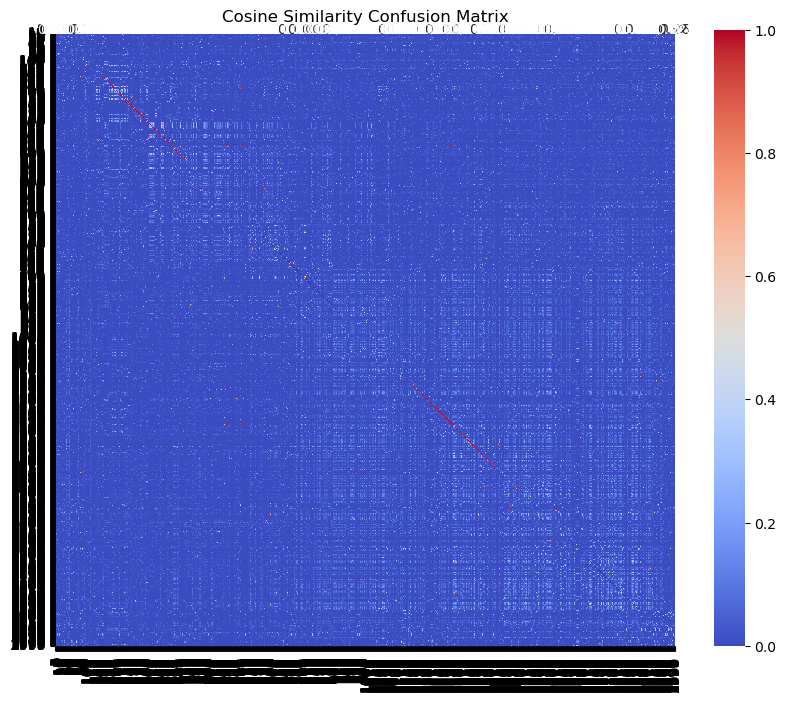

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidf_matrix = vectorizer.fit_transform(norm_corpus)

# Calculate cosine similarity between all pairs of documents
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Visualize the similarity matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, annot=True, cmap='coolwarm', xticklabels=range(1, len(norm_corpus)+1),
            yticklabels=range(1, len(norm_corpus)+1))
plt.title('Cosine Similarity Confusion Matrix')
plt.show()


In [20]:
len(norm_corpus)

2000

In [25]:
norm_corpus=norm_corpus[0:50]
len(norm_corpus)

50

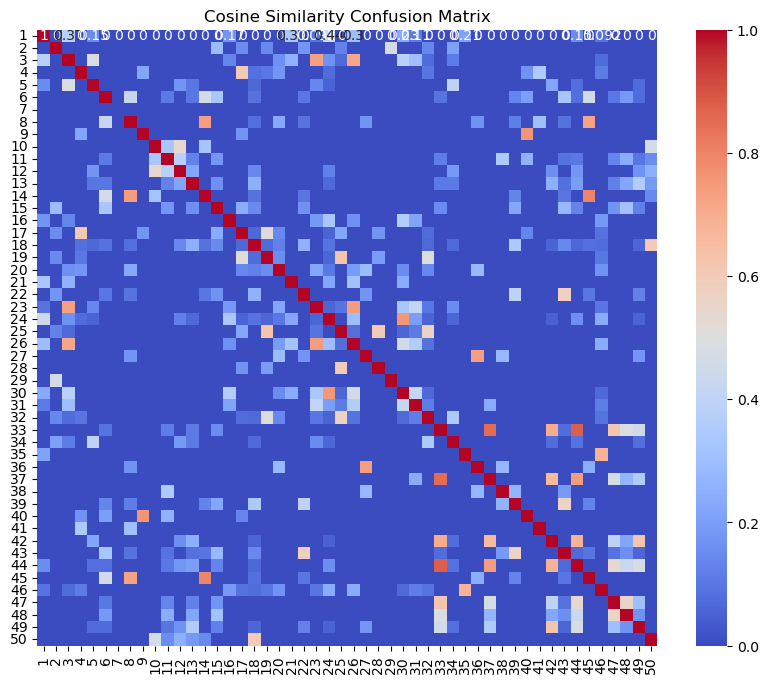

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidf_matrix = vectorizer.fit_transform(norm_corpus)

# Calculate cosine similarity between all pairs of documents
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Visualize the similarity matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim, annot=True, cmap='coolwarm', xticklabels=range(1, len(norm_corpus)+1),
            yticklabels=range(1, len(norm_corpus)+1))
plt.title('Cosine Similarity Confusion Matrix')
plt.show()


In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a labeled dataset with true labels (0 for not similar, 1 for similar)
true_labels = np.array([1, 0, 1, 0, 1])

# Initialize an empty list to store predicted labels
predicted_labels = []

# Menghitung akurasi dan mengisi predicted_labels
for i in range(len(test_data)):
    predicted_index = cosine_similarities[i].argmax()
    print(f'Test Data: {test_data[i]}')
    print(f'Predicted Document: {norm_corpus[predicted_index]}')
    print(f'Cosine Similarity: {cosine_similarities[i][predicted_index]}')
    print('---')
    if cosine_similarities[i][predicted_index] >= 0.7:
        predicted_labels.append(1)  # Similar
    else:
        predicted_labels.append(0)  # Not similar

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Similar', 'Similar'], yticklabels=['Not Similar', 'Similar'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f'Accuracy: {accuracy * 100:.2f}%')


Test Data: Sprint Race MotoGP Batal: Martin Kecewa Gagal Dekati Bagnaia


IndexError: list index out of range